In [1]:
import cv2
import math
import scipy
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from plantcv import plantcv as pcv
from scipy.interpolate import griddata, interp2d

In [2]:
def get_non_uniform_sampling(source, steps):
    shape = np.shape(source)
    height = shape[0]
    length = shape[1]
    
    x_centre = int(length/2)
    y_centre = int(height/2)
    radius = int(min(length, height)/2)
    
    pi = np.pi
    multiplier = 0.5
    x_coordinates = []
    y_coordinates = []

    for r in steps:
        number_of_points = (1/multiplier) * 2

        for j in range(int(number_of_points)):
            theta = j*pi*multiplier
            x = x_centre + (r * np.cos(theta))
            y = y_centre + (r * np.sin(theta))
            if(x<length and y<height):
                x_coordinates.append(int(x))
                y_coordinates.append(int(y))

        multiplier = multiplier/1.75
    
    return x_coordinates, y_coordinates

def window_stdev(X, window_size):
    c1 = uniform_filter(X, window_size, mode='reflect')
    c2 = uniform_filter(X*X, window_size, mode='reflect')
    return np.sqrt(c2 - c1*c1)

In [3]:
img = cv2.imread("./Images/OS0043EY.JPG")
print(np.shape(img))
(B,G,R) = cv2.split(img)
#cv2.imshow("Source Image", img)
#cv2.waitKey(0)

(1248, 1664, 3)


In [4]:
steps = [0, 149, 246, 357, 486, 574]
x_coordinates, y_coordinates = get_non_uniform_sampling(G, steps)
number_of_points = (np.shape(x_coordinates))[0]
print("The number of points is", number_of_points)

The number of points is 146


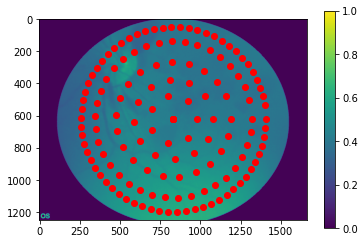

In [5]:
plt.rcParams["figure.figsize"] = (8,8)
plt.imshow(G)
plt.scatter(x_coordinates, y_coordinates, color='red')
plt.colorbar()

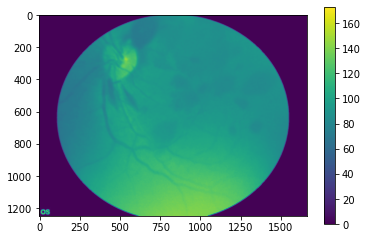

In [6]:
figure_size = 7
G_mean = cv2.blur(G,(figure_size, figure_size))
plt.imshow(G_mean)
plt.colorbar()

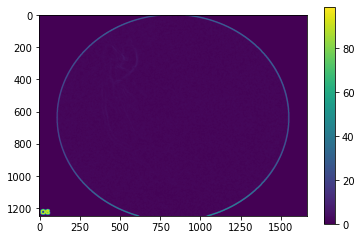

In [7]:
G_std = pcv.stdev_filter(img=G, ksize=7, borders='nearest')
plt.imshow(G_std)
plt.colorbar()

In [8]:
mean = np.empty(number_of_points)
std = np.empty(number_of_points)
G_mean_interpolation = np.zeros(np.shape(G))
G_mean_interpolation[:,:] = np.nan
G_std_interpolation = np.zeros(np.shape(G))
G_std_interpolation[:,:] = np.nan

for i in range(number_of_points):
    x = x_coordinates[i]
    y = y_coordinates[i]
    
    mean[i] = G_mean[y, x]
    std[i] = G_std[y, x]
    
    G_mean_interpolation[y, x] = mean[i]
    G_std_interpolation[y, x] = std[i]

In [9]:
#ax = plt.axes(projection ="3d")
#ax.scatter3D(x_coordinates, y_coordinates, mean)
#plt.show()

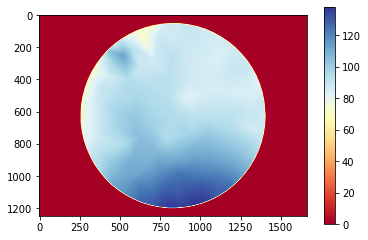

In [10]:
xi = np.arange(0, np.shape(G)[1], 1)
yi = np.arange(0, np.shape(G)[0], 1)
x_grid, y_grid = np.meshgrid(xi, yi)

points = []
for i , j in zip(x_coordinates, y_coordinates):
    points.append([i,j])

interpolated_mean = scipy.interpolate.griddata(points, mean, (x_grid, y_grid) , method='linear', fill_value=0, rescale=False)

plt.imshow(interpolated_mean, cmap = 'RdYlBu')
plt.colorbar()

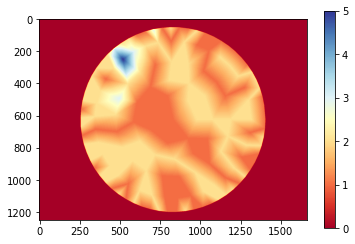

In [11]:
interpolated_std = scipy.interpolate.griddata(points, std, (x_grid, y_grid) , method='linear', fill_value=0, rescale=False)

plt.imshow(interpolated_std, cmap = 'RdYlBu')
plt.colorbar()

In [12]:
height = np.shape(G)[0]
length = np.shape(G)[1]
mahalanobis = np.empty(np.shape(G))

for i in range(height):
    for j in range(length):
        mahalanobis[i, j] = (G[i, j] - interpolated_mean[i, j])/interpolated_std[i, j]
        if(mahalanobis[i, j] >= 0.75):
            mahalanobis[i, j] = 1
        else:
            mahalanobis[i, j] = 0

C:\Users\aniru\AppData\Local\Temp/ipykernel_8216/3597418823.py:7: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\aniru\AppData\Local\Temp/ipykernel_8216/3597418823.py:7: RuntimeWarning: invalid value encountered in double_scalars


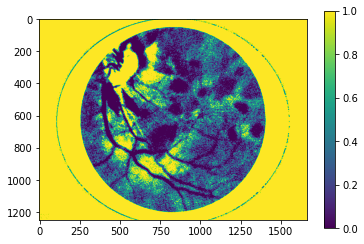

In [13]:
plt.imshow(mahalanobis)
plt.colorbar()